Laplacian Eigenmaps
==================

Extract from Wikipedia:

_"Laplacian Eigenmaps uses spectral techniques to perform dimensionality reduction.[13] This technique relies on the basic assumption that the data lies in a low-dimensional manifold in a high-dimensional space.[14] This algorithm cannot embed out-of-sample points, but techniques based on Reproducing kernel Hilbert space regularization exist for adding this capability.[15] Such techniques can be applied to other nonlinear dimensionality reduction algorithms as well."_

**source**: https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Laplacian_eigenmaps

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

We will first get an easy to visualise dataset, in order to see the final feature transformation. Here we show only the first two features of the dataset.

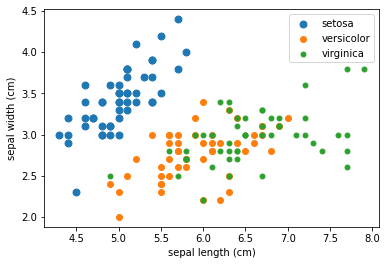

In [2]:
iris = load_iris()
X = iris['data']
y = iris['target']
classes = iris['target_names']
features = iris['feature_names']

fig, ax = plt.subplots()
for i in np.unique(y):
    ax.scatter(X[y==i, 0], X[y==i, 1], label=classes[i], s=(3-i+1)*12)
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.legend()

PCA in feature space
------------------------------

We can perform Principal Component Analysis into the raw features to reduce its dimentionallity to 2 and see the transformed samples.

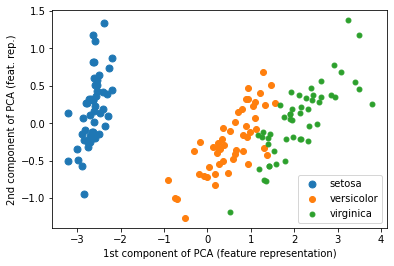

In [3]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, ax = plt.subplots()
for i in np.unique(y):
    ax.scatter(X_pca[y==i, 0], X_pca[y==i, 1], label=classes[i], s=(3-i+1)*12)
ax.set_xlabel('1st component of PCA (feature representation)')
ax.set_ylabel('2nd component of PCA (feat. rep.)')
ax.legend()

## Distance matrix

Here we compute the distance matrix between every pair of samples

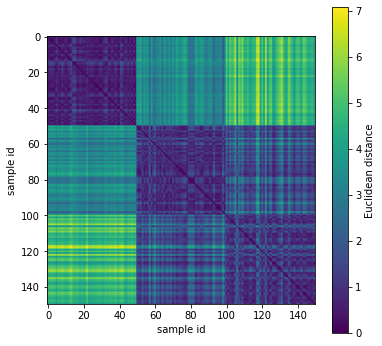

In [4]:
from sklearn.metrics import pairwise_distances

distance_m = pairwise_distances(X)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(distance_m)
ax.set_xlabel('sample id')
ax.set_ylabel('sample id')
bar = fig.colorbar(im)
bar.set_label('Euclidean distance')

Lets look at the distances from all samples to the 1st and 2nd sample

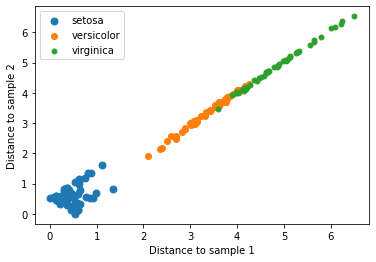

In [5]:
fig, ax = plt.subplots()
for i in np.unique(y):
    ax.scatter(distance_m[y==i, 0], distance_m[y==i, 1], label=classes[i], s=(3-i+1)*12)
ax.set_xlabel('Distance to sample 1')
ax.set_ylabel('Distance to sample 2')
ax.legend()

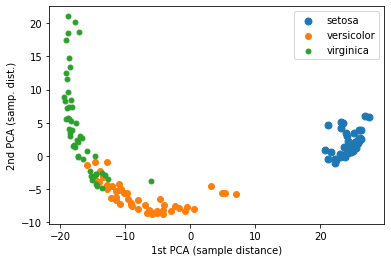

In [6]:
pca = PCA(n_components=2)
distance_m_pca = pca.fit_transform(distance_m)

fig, ax = plt.subplots()
for i in np.unique(y):
    ax.scatter(distance_m_pca[y==i, 0], distance_m_pca[y==i, 1], label=classes[i], s=(3-i+1)*12)
ax.set_xlabel('1st PCA (sample distance)')
ax.set_ylabel('2nd PCA (samp. dist.)')
ax.legend()

# k-Nearest Neighbour adjacency matrix

Here we decide a number of neighbours $k$ to consider two samples adjacent and compute the adjacency matrix.

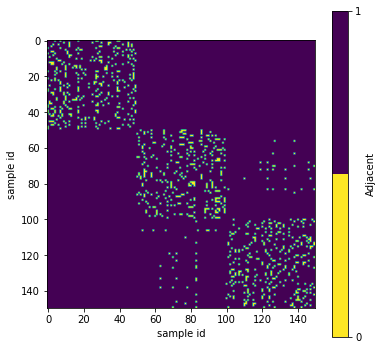

In [7]:
adjacency_m = np.zeros_like(distance_m)

k = 7
for i, row in enumerate(distance_m):
    closer_indices = np.argsort(row)[:k+1]
    adjacency_m[i, closer_indices] = 1

adjacency_m -= np.eye(len(adjacency_m))

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(adjacency_m, interpolation=None)
ax.set_xlabel('sample id')
ax.set_ylabel('sample id')
bar = fig.colorbar(im, values=[0, 1], ticks=[0, 1])
bar.set_label('Adjacent')

## Laplacian matrix

The Laplacian matrix can be compute given its degree matrix $D$ and its adjacency matrix $A$ as

$$L = D - A$$

Where every element of the diagonal is the number of output connections of every node (in this case all of them are $k$), while the off-diagonal elements are zero if the nodes are not adjacent and $-1$ if they are. This means that every row of the matrix sums to zero. 

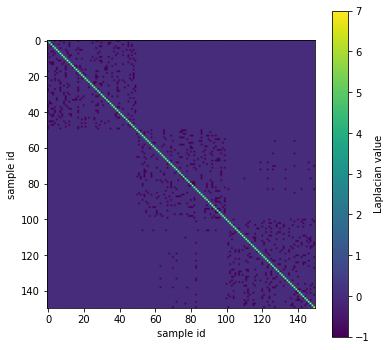

In [8]:
degree_m = np.eye(len(adjacency_m))*k

laplacian_m = degree_m - adjacency_m

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(laplacian_m)
ax.set_xlabel('sample id')
ax.set_ylabel('sample id')
bar = fig.colorbar(im)
bar.set_label('Laplacian value')

Laplacian eigenmaps
-------------------

We can perform dimentionality reduction on the Laplacian matrix 

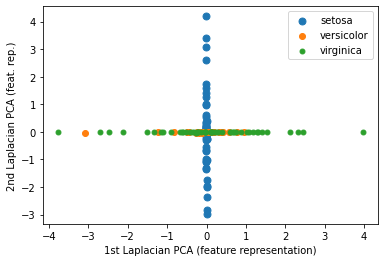

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
G_pca = pca.fit_transform(laplacian_m)

fig, ax = plt.subplots()
for i in np.unique(y):
    ax.scatter(G_pca[y==i, 0], G_pca[y==i, 1], label=classes[i], s=(3-i+1)*12)
ax.set_xlabel('1st Laplacian PCA (feature representation)')
ax.set_ylabel('2nd Laplacian PCA (feat. rep.)')
ax.legend()

## Eigenmaps of degree + adjacency

<span style="color:red">Before doing the previous plot of the Laplacian eigenmaps, I made a a mistake and instead of computing the Laplacian of the matrix I computed the sum of the degree and adjacency matrix.</span>
$$ ? = D + A $$
<span>The resulting dimensionallity reduction looks much better than the Laplacian eigenmaps. Not sure what this is then.</span>

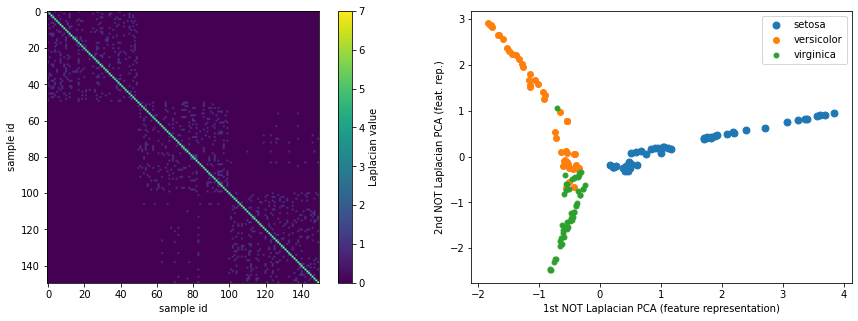

In [10]:
degree_m = np.eye(len(adjacency_m))*k

no_laplacian_m = degree_m + adjacency_m

pca = PCA(n_components=2)
G_pca = pca.fit_transform(no_laplacian_m)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
im = ax[0].imshow(no_laplacian_m)
ax[0].set_xlabel('sample id')
ax[0].set_ylabel('sample id')
bar = fig.colorbar(im, ax=ax[0])
bar.set_label('Laplacian value')

for i in np.unique(y):
    ax[1].scatter(G_pca[y==i, 0], G_pca[y==i, 1], label=classes[i], s=(3-i+1)*12)
ax[1].set_xlabel('1st NOT Laplacian PCA (feature representation)')
ax[1].set_ylabel('2nd NOT Laplacian PCA (feat. rep.)')
ax[1].legend()

# Example reduction

Similar to the previous dimensionality reduction method, we could be interested on reducing the samples instead of the dimensions. In order to do that, we can work with the original input space $X$ which has number of samples in the rows, and number of dimensions in the columns and transpose it. We obtain a sample space $X^T$ with features in the rows and samples in the columns. We are now interested on reducing the samples to the most informative ones in terms of variance.

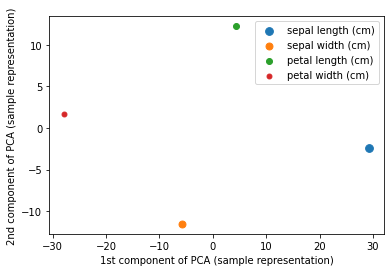

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_T_pca = pca.fit_transform(X.T)

fig, ax = plt.subplots()
for i in range(len(features)):
    ax.scatter(X_T_pca[i, 0], X_T_pca[i, 1], label=features[i], s=(4-i+1)*12)
ax.set_xlabel('1st component of PCA (sample representation)')
ax.set_ylabel('2nd component of PCA (sample representation)')
ax.legend()

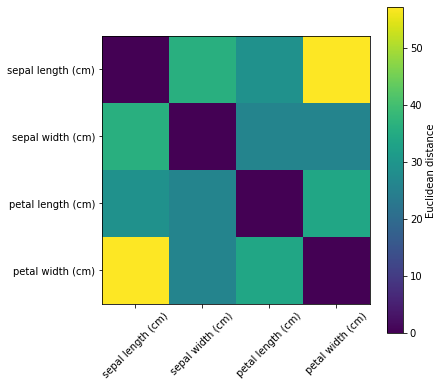

In [12]:
from sklearn.metrics import pairwise_distances

distance_m = pairwise_distances(X.T)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(distance_m)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features, rotation=45)
bar = fig.colorbar(im)
bar.set_label('Euclidean distance')

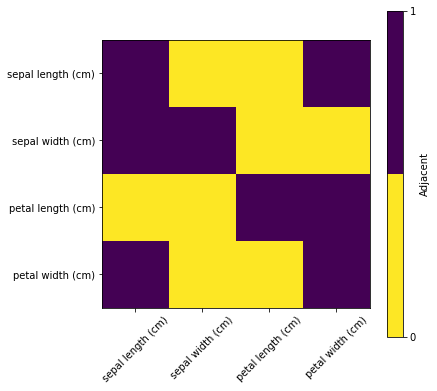

In [13]:
adjacency_m = np.zeros_like(distance_m)

k = 2
for i, row in enumerate(distance_m):
    closer_indices = np.argsort(row)[:k+1]
    adjacency_m[i, closer_indices] = 1

adjacency_m -= np.eye(len(adjacency_m))

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(adjacency_m)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features, rotation=45)
bar = fig.colorbar(im, values=[0, 1], ticks=[0, 1])
bar.set_label('Adjacent')

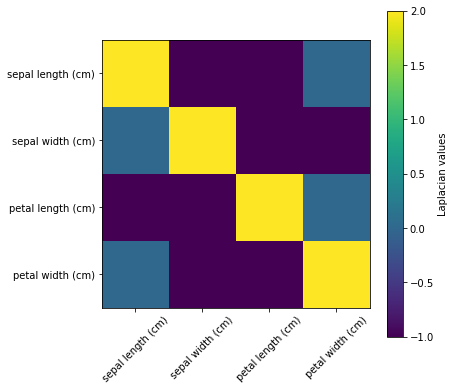

In [14]:
degree_m = np.eye(len(adjacency_m))*k

laplacian_m = degree_m - adjacency_m

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(laplacian_m)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features, rotation=45)
bar = fig.colorbar(im)
bar.set_label('Laplacian values')

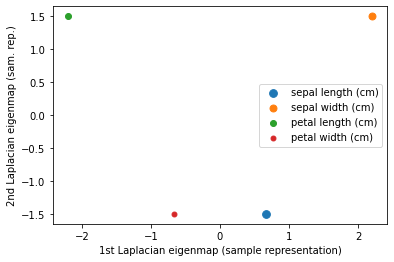

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
G_pca = pca.fit_transform(laplacian_m)

fig, ax = plt.subplots()
for i in range(len(features)):
    ax.scatter(G_pca[i, 0], G_pca[i, 1], label=features[i], s=(4-i+1)*12)
ax.set_xlabel('1st Laplacian eigenmap (sample representation)')
ax.set_ylabel('2nd Laplacian eigenmap (sam. rep.)')
ax.legend()